In [1]:
!pip install transformers
!pip install transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Let’s start with a complete example, taking a look at what happened behind the scenes when we executed the following code in [Chapter 1](https://huggingface.co/course/chapter1)
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9598049521446228},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

this pipeline groups together three steps: preprocessing, passing the inputs through the model, and postprocessing:
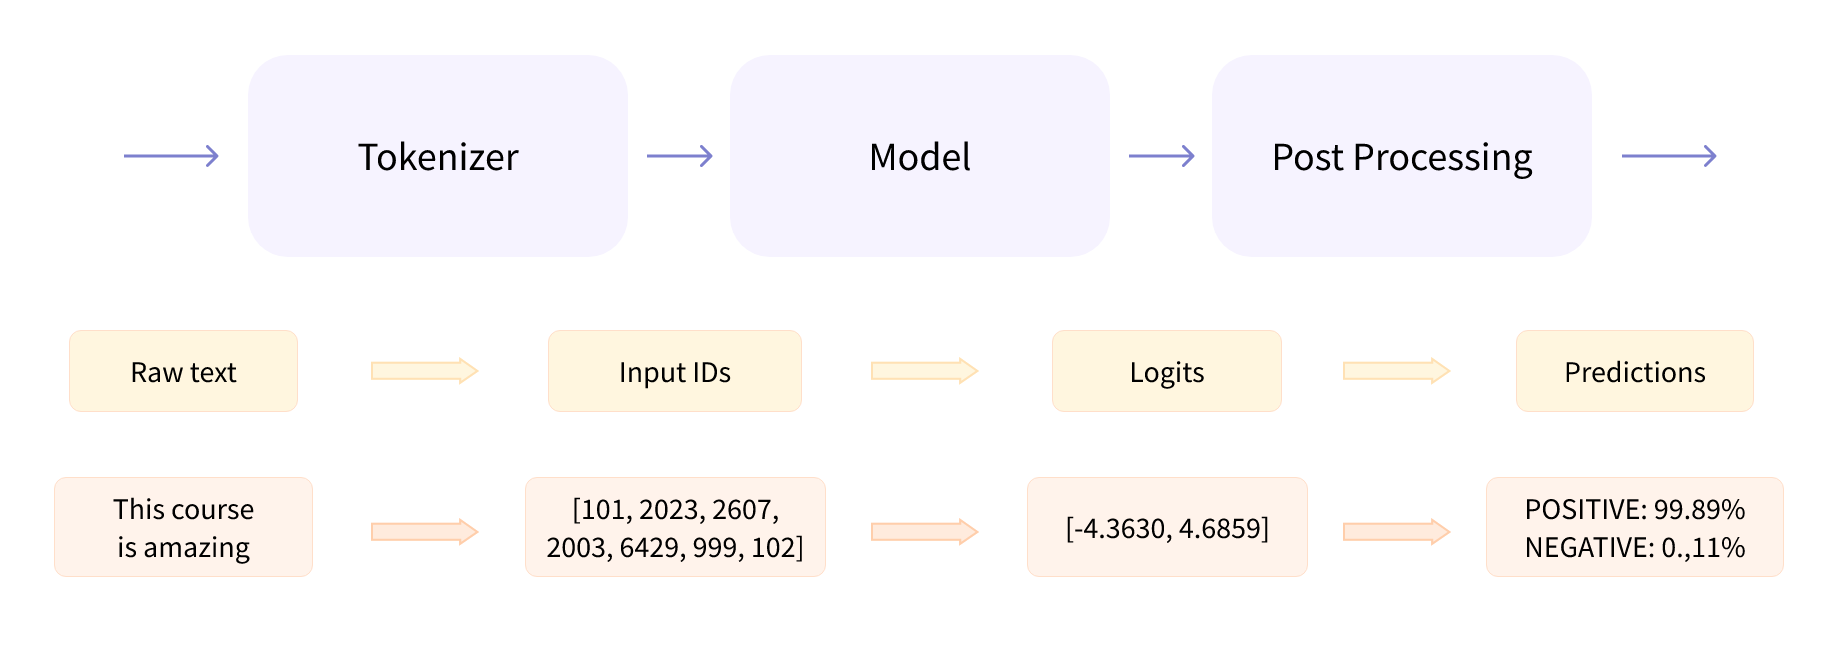

## Preprocessing with a tokenizer
Like other neural networks, Transformer models can’t process raw text directly, so the first step of our pipeline is to convert the text inputs into numbers that the model can make sense of. To do this we use a tokenizer, which will be responsible for:

Splitting the input into words, subwords, or symbols (like punctuation) that are called tokens
Mapping each token to an integer
Adding additional inputs that may be useful to the model  
Since the default checkpoint of the sentiment-analysis pipeline is distilbert-base-uncased-finetuned-sst-2-english (you can see its model card here), we run the following:

In [3]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Once we have the tokenizer, we can directly pass our sentences to it and we’ll get back a dictionary that’s ready to feed to our model! The only thing left to do is to convert the list of input IDs to tensors.  

You can use 🤗 Transformers without having to worry about which ML framework is used as a backend; it might be PyTorch or TensorFlow, or Flax for some models. However, **Transformer models only accept tensors as input.** If this is your first time hearing about tensors, you can think of them as NumPy arrays instead. A NumPy array can be a scalar (0D), a vector (1D), a matrix (2D), or have more dimensions. It’s effectively a tensor; other ML frameworks’ tensors behave similarly, and are usually as simple to instantiate as NumPy arrays.  

To specify the type of tensors we want to get back (PyTorch, TensorFlow, or plain NumPy), we use the return_tensors argument:

In [4]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


The output itself is a dictionary containing two keys, input_ids and attention_mask. input_ids contains two rows of integers (one for each sentence) that are the unique identifiers of the tokens in each sentence. We’ll explain what the attention_mask is later in this chapter.

In [5]:
## Going through the model
# We can download our pretrained model the same way we did with our tokenizer. 🤗 Transformers provides an AutoModel class which also has a from_pretrained() method:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


This architecture contains only the base Transformer module: given some inputs, it outputs what we’ll call hidden states, also known as features. For each model input, we’ll retrieve a high-dimensional vector representing the contextual understanding of that input by the Transformer model.  
A high-dimensional vector?
The vector output by the Transformer module is usually large. It generally has three dimensions:

Batch size: The number of sequences processed at a time (2 in our example).
Sequence length: The length of the numerical representation of the sequence (16 in our example).
Hidden size: The vector dimension of each model input.
It is said to be “high dimensional” because of the last value. The hidden size can be very large (768 is common for smaller models, and in larger models this can reach 3072 or more).

We can see this if we feed the inputs we preprocessed to our model:

In [6]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 16, 768])


Note that the outputs of 🤗 Transformers models behave like namedtuples or dictionaries. You can access the elements by attributes (like we did) or by key (outputs["last_hidden_state"]), or even by index if you know exactly where the thing you are looking for is (outputs[0]).

There are many different architectures available in 🤗 Transformers, with each one designed around tackling a specific task. Here is a non-exhaustive list:  

*Model (retrieve the hidden states)  
*ForCausalLM  
*ForMaskedLM  
*ForMultipleChoice  
*ForQuestionAnswering  
*ForSequenceClassification  
*ForTokenClassification  
and others 🤗  
For our example, we will need a model with a sequence classification head (to   be able to classify the sentences as positive or negative). So, we won’t  actually use the AutoModel class, but AutoModelForSequenceClassification:

In [ ]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

In [ ]:
# Now if we look at the shape of our outputs, the dimensionality will be much lower: the model head takes as input the high-dimensional vectors we saw before, and outputs vectors containing two values (one per label):
print(outputs.logits.shape)

In [ ]:
## Postprocessing the output
# The values we get as output from our model don’t necessarily make sense by themselves. Let’s take a look:
print(outputs.logits)

Our model predicted [-1.5607, 1.6123] for the first sentence and [ 4.1692, -3.3464] for the second one. Those are not probabilities but logits, the raw, unnormalized scores outputted by the last layer of the model. To be converted to probabilities, they need to go through a SoftMax layer (all 🤗 Transformers models output the logits, as the loss function for training will generally fuse the last activation function, such as SoftMax, with the actual loss function, such as cross entropy):

In [ ]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

To get the labels corresponding to each position, we can inspect the id2label attribute of the model config (more on this in the next section):

In [ ]:
model.config.id2label

Now we can conclude that the model predicted the following:

First sentence: NEGATIVE: 0.0402, POSITIVE: 0.9598  
Second sentence: NEGATIVE: 0.9995, POSITIVE: 0.0005